Given some geometry and a time window, extract pixel values over that time period

In [3]:
import ee
import geemap
import os

from typing import Tuple
import json
import numpy as np
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import pandas as pd
import geopandas as gpd
from geopandas import GeoDataFrame
from shapely.geometry import Polygon

In [9]:
bb: Tuple[int] = (-62.94205,  -9.16795, -61.58455,  -7.77635)
ee_aoi = ee.Geometry.Rectangle(bb)

In [10]:
gdf_mapb = gpd.read_file('/Users/janpisl/Documents/EPFL/workdir/sample_data/mapbiomas_2021.gpkg')

aoi: Polygon = Polygon([ [bb[0], bb[1]], [bb[0], bb[3]], [bb[2], bb[3]], [bb[2],bb[1]]])
mapb_subset = gdf_mapb.loc[gdf_mapb.geometry.intersects(aoi)]
mapb_ee = geemap.gdf_to_ee(mapb_subset)


In [143]:
gdf_mapb.loc[gdf_mapb.Bioma == 'AMAZÔNIA'].loc[gdf_mapb.AreaHa > 100].sample().IDAlerta.values[0]

397209

In [144]:
dst = gdf_mapb.loc[gdf_mapb.Bioma == 'AMAZÔNIA'].loc[gdf_mapb.AreaHa > 100]
for i in range(10):
    one_geometry = dst.sample() 
    one_geometry.to_file(f'samples/IDAlerta_{one_geometry.IDAlerta.values[0]}_{one_geometry.DataDetec.values[0]}.shp')


,IDAlerta,CodeAlerta,Fonte,Bioma,Estado,Municipio,AreaHa,AnoDetec,DataDetec,geometry
39367,431717,430359,{DETERB-AMAZONIA},AMAZÔNIA,PARÁ,PORTEL,117.32,2021.0,2021-09-15,"MULTIPOLYGON (((-51.69166 -2.62568, -51.69166 ..."


In [70]:
start_str = '2020-01-01'
end_str = '2020-01-03'

In [84]:
mosaic = ee.ImageCollection('COPERNICUS/S1_GRD') \
    .filterBounds(ee_aoi) \
    .filterDate(ee.Date(start_str), ee.Date(end_str))\
    .select(['VV', 'VH'])\
    .mosaic().getInfo()
    
    

In [85]:
mosaic

{'type': 'Image',
 'bands': [{'id': 'VV',
   'data_type': {'type': 'PixelType', 'precision': 'double'},
   'crs': 'EPSG:4326',
   'crs_transform': [1, 0, 0, 0, 1, 0]},
  {'id': 'VH',
   'data_type': {'type': 'PixelType', 'precision': 'double'},
   'crs': 'EPSG:4326',
   'crs_transform': [1, 0, 0, 0, 1, 0]}]}

In [72]:
Map = geemap.Map(center=[-9.04618993283354, -62.911282916381275], zoom=9)
Map.addLayer(mosaic, {}, 'S-1')
Map.addLayer(ee_aoi, {}, 'aoi')
Map.addLayer(mapb_ee)
Map

Map(center=[-9.04618993283354, -62.911282916381275], controls=(WidgetControl(options=['position', 'transparent…

In [86]:
dates = pd.date_range('2020-01-01', periods=24, freq='w')

series = []

for i in range(len(dates)-1):
    st = dates[i]
    end = dates[i+1]
    start_str = f'{st.year}-{st.month}-{st.day}'
    end_str = f'{end.year}-{end.month}-{end.day}'



    mosaic = ee.ImageCollection('COPERNICUS/S1_GRD') \
        .filterBounds(ee_aoi) \
        .filterDate(ee.Date(start_str), ee.Date(end_str))\
        .filterMetadata('transmitterReceiverPolarisation', 'equals', ['VV', 'VH'])\
        .select(['VV', 'VH'])\
        .mosaic()


    series.append(mosaic)

coll = ee.ImageCollection(series)
labels = coll.aggregate_array("system:index").getInfo()

In [92]:
coll.getInfo()

{'type': 'ImageCollection',
 'bands': [],
 'features': [{'type': 'Image',
   'bands': [{'id': 'VV',
     'data_type': {'type': 'PixelType', 'precision': 'double'},
     'crs': 'EPSG:4326',
     'crs_transform': [1, 0, 0, 0, 1, 0]},
    {'id': 'VH',
     'data_type': {'type': 'PixelType', 'precision': 'double'},
     'crs': 'EPSG:4326',
     'crs_transform': [1, 0, 0, 0, 1, 0]}],
   'properties': {'system:index': '0'}},
  {'type': 'Image',
   'bands': [{'id': 'VV',
     'data_type': {'type': 'PixelType', 'precision': 'double'},
     'crs': 'EPSG:4326',
     'crs_transform': [1, 0, 0, 0, 1, 0]},
    {'id': 'VH',
     'data_type': {'type': 'PixelType', 'precision': 'double'},
     'crs': 'EPSG:4326',
     'crs_transform': [1, 0, 0, 0, 1, 0]}],
   'properties': {'system:index': '1'}},
  {'type': 'Image',
   'bands': [{'id': 'VV',
     'data_type': {'type': 'PixelType', 'precision': 'double'},
     'crs': 'EPSG:4326',
     'crs_transform': [1, 0, 0, 0, 1, 0]},
    {'id': 'VH',
     'data_ty

In [87]:
values = coll.toBands()

In [88]:
out_dir = os.path.join(os.path.expanduser('~'), 'Downloads')
out_stats = os.path.join(out_dir, 'stats.csv')

if not os.path.exists(out_dir):
    os.makedirs(out_dir)

# Allowed output formats: csv, shp, json, kml, kmz
# Allowed statistics type: MEAN, MAXIMUM, MINIMUM, MEDIAN, STD, MIN_MAX, VARIANCE, SUM
geemap.zonal_statistics(values, mapb_ee, out_stats, statistics_type='MEAN', scale=1000)

Computing statistics ...
Generating URL ...
Please wait ...
Data downloaded to /Users/janpisl/Downloads/stats.csv


In [89]:
import pandas as pd

df = pd.read_csv(out_stats)
df

,0_VV,0_VH,1_VV,1_VH,2_VV,2_VH,3_VV,3_VH,4_VV,4_VH,...,system:index,Municipio,DataDetec,AreaHa,Fonte,IDAlerta,AnoDetec,CodeAlerta,Bioma,Estado
0,-8.213942,-14.238417,-8.559315,-14.211689,-7.798593,-13.572518,-8.032646,-13.864255,-7.863946,-13.884010,...,0,CUJUBIM,2021-01-01,23.20,"{DETERB-AMAZONIA,SAD}",305335,2021,305257,AMAZÔNIA,RONDÔNIA
1,-7.297945,-13.762464,-7.166586,-13.511184,-7.390404,-13.887466,-7.068442,-13.683785,-7.365652,-13.731447,...,1,PORTO VELHO,2021-01-01,11.59,{SAD},305717,2021,305639,AMAZÔNIA,RONDÔNIA
2,-8.863680,-14.958925,-8.589712,-14.381214,-8.184171,-14.037794,-8.157028,-14.269442,-8.629994,-14.733459,...,2,CUJUBIM,2021-01-01,10.43,{SAD},305726,2021,305648,AMAZÔNIA,RONDÔNIA
3,-7.621994,-14.071277,-7.479684,-13.597933,-7.661167,-13.910598,-7.331699,-13.731809,-7.786914,-14.051094,...,3,CANDEIAS DO JAMARI,2021-01-01,20.18,{SAD},306147,2021,306069,AMAZÔNIA,RONDÔNIA
4,-7.234708,-14.030771,-7.694816,-13.854764,-7.085627,-13.677729,-6.748229,-13.380815,-8.374101,-14.398911,...,4,MACHADINHO D'OESTE,2021-01-01,11.70,{SAD},306148,2021,306070,AMAZÔNIA,RONDÔNIA
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
425,-8.063672,-14.553907,-7.542768,-13.784372,-8.103131,-14.513745,-7.596874,-13.950098,-7.838478,-13.802540,...,425,MACHADINHO D'OESTE,2021-11-01,5.26,{SAD},493218,2021,491860,AMAZÔNIA,RONDÔNIA
426,-8.075316,-14.712868,-7.575566,-13.978189,-8.314723,-14.673360,-7.662657,-14.146208,-8.182936,-14.381676,...,426,MACHADINHO D'OESTE,2021-11-01,7.37,{SAD},493825,2021,492467,AMAZÔNIA,RONDÔNIA
427,-6.895386,-13.387631,-8.186963,-14.233650,-7.550067,-14.006186,-6.677122,-13.392452,-8.395843,-14.564904,...,427,MACHADINHO D'OESTE,2021-11-01,6.01,{SAD},493971,2021,492613,AMAZÔNIA,RONDÔNIA
428,-6.844207,-13.700690,-8.315523,-14.481795,-6.780437,-13.157213,-6.270770,-12.937430,-8.645888,-14.660891,...,428,MANICORÉ,2021-11-01,7.61,{SAD},494339,2021,492981,AMAZÔNIA,AMAZONAS


In [94]:
cols = [col for col in df.columns.tolist() if 'VV' not in col]
cols

['0_VH',
 '1_VH',
 '2_VH',
 '3_VH',
 '4_VH',
 '5_VH',
 '6_VH',
 '7_VH',
 '8_VH',
 '9_VH',
 '10_VH',
 '11_VH',
 '12_VH',
 '13_VH',
 '14_VH',
 '15_VH',
 '16_VH',
 '17_VH',
 '18_VH',
 '19_VH',
 '20_VH',
 '21_VH',
 '22_VH',
 'system:index',
 'Municipio',
 'DataDetec',
 'AreaHa',
 'Fonte',
 'IDAlerta',
 'AnoDetec',
 'CodeAlerta',
 'Bioma',
 'Estado']

<AxesSubplot:>

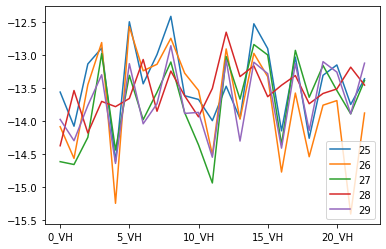

In [105]:
df[[col for col in df.columns if 'VH' in col]].iloc[25:30].T.plot()

This further down is from a tutorial

In [4]:
# Add Earth Engine dataset
dem = ee.Image('USGS/SRTMGL1_003')

# Set visualization parameters.
dem_vis = {
    'min': 0,
    'max': 4000,
    'palette': ['006633', 'E5FFCC', '662A00', 'D8D8D8', 'F5F5F5'],
}

# Add Earth Engine DEM to map
Map.addLayer(dem, dem_vis, 'SRTM DEM')

# Add Landsat data to map
landsat = ee.Image('LE7_TOA_5YEAR/1999_2003')

landsat_vis = {'bands': ['B4', 'B3', 'B2'], 'gamma': 1.4}
Map.addLayer(landsat, landsat_vis, "LE7_TOA_5YEAR/1999_2003")

states = ee.FeatureCollection("TIGER/2018/States")
Map.addLayer(states, {}, 'US States')

In [ ]:
out_dir = os.path.join(os.path.expanduser('~'), 'Downloads')
out_stats = os.path.join(out_dir, 'stats.csv')

if not os.path.exists(out_dir):
    os.makedirs(out_dir)

# Allowed output formats: csv, shp, json, kml, kmz
# Allowed statistics type: MEAN, MAXIMUM, MINIMUM, MEDIAN, STD, MIN_MAX, VARIANCE, SUM
geemap.zonal_statistics(dem, states, out_stats, statistics_type='MEAN', scale=1000)

In [ ]:
import pandas as pd

df = pd.read_csv(out_stats)
df

In [ ]:
#  Is it possible to extract Zonal Statistics for a time series of data, like monthly NDVI, and export to CSV?
# Simply convert your ImageCollection to Image using collection.toBands() and then follow the same tutorial to compute zonal statistics.

In [4]:
gdf_mapb = gpd.read_file('/Users/janpisl/Documents/EPFL/workdir/sample_data/MapBiomas/dashboard_alerts-shapefilePolygon.shp')


In [1]:
item = gdf_mapb.loc[gdf_mapb.IDAlerta == 495990]
item.total_bounds
item.to_file('IDAlerta_495990.shp')

NameError: name 'gdf_mapb' is not defined

In [8]:
item = gdf_mapb.loc[gdf_mapb.IDAlerta == 305393]
item.to_file('IDAlerta_305393.shp')


In [9]:
item.total_bounds

array([-59.44958922,   1.11774676, -59.43363514,   1.13765343])

In [ ]:
deter = gpd.read_file('/Users/janpisl/Documents/EPFL/workdir/sample_data/DETER/deter_public.shp')


In [184]:
deter.loc[deter.PATH_ROW == '178099'].loc[deter.GEOCODIBGE == '1400027']

#

,CLASSNAME,QUADRANT,PATH_ROW,VIEW_DATE,SENSOR,SATELLITE,AREAUCKM,UC,AREAMUNKM,MUNICIPALI,GEOCODIBGE,UF,geometry
16333,DESMATAMENTO_CR,None,178099,2021-12-16,AWFI,CBERS-4,0.0,None,0.103337,Amajari,1400027,RR,"POLYGON ((-61.81839 3.86073, -61.81817 3.86247..."
50474,DESMATAMENTO_CR,None,178099,2019-01-12,AWFI,CBERS-4,0.0,None,0.146101,Amajari,1400027,RR,"POLYGON ((-61.79452 3.82540, -61.79035 3.82540..."
54921,MINERACAO,None,178099,2019-02-07,AWFI,CBERS-4,0.0,None,0.129357,Amajari,1400027,RR,"POLYGON ((-63.28391 3.61816, -63.28391 3.61888..."
54922,MINERACAO,None,178099,2019-02-07,AWFI,CBERS-4,0.0,None,0.071463,Amajari,1400027,RR,"POLYGON ((-63.28751 3.64503, -63.28751 3.64743..."
54923,MINERACAO,None,178099,2019-02-07,AWFI,CBERS-4,0.0,None,0.085316,Amajari,1400027,RR,"POLYGON ((-63.28123 3.63564, -63.28067 3.63555..."
55970,DESMATAMENTO_CR,None,178099,2019-01-12,AWFI,CBERS-4,0.0,None,0.417325,Amajari,1400027,RR,"POLYGON ((-61.94420 3.75782, -61.94791 3.75460..."
57480,MINERACAO,None,178099,2019-02-07,AWFI,CBERS-4,0.0,None,0.239216,Amajari,1400027,RR,"POLYGON ((-63.28283 3.64035, -63.28294 3.63997..."
65838,DESMATAMENTO_CR,None,178099,2019-03-05,AWFI,CBERS-4,0.0,None,0.097956,Amajari,1400027,RR,"POLYGON ((-61.84501 3.86893, -61.84501 3.86859..."
65975,DESMATAMENTO_CR,None,178099,2019-03-05,AWFI,CBERS-4,0.0,None,0.065698,Amajari,1400027,RR,"POLYGON ((-61.89102 3.52930, -61.89201 3.52793..."
66071,DESMATAMENTO_CR,None,178099,2019-03-05,AWFI,CBERS-4,0.0,None,0.181447,Amajari,1400027,RR,"POLYGON ((-61.85419 3.86859, -61.85385 3.86825..."


In [1]:
import geopandas as gpd

path = '/Users/janpisl/Documents/EPFL/workdir/sample_data/MapBiomas/dashboard_alerts-shapefilePolygon.shp'
mapb = gpd.read_file(path)
mapb

,fid,IDAlerta,CodeAlerta,Fonte,Bioma,Estado,Municipio,AreaHa,AnoDetec,DataDetec,geometry
0,44,44,44,"{DETERB-AMAZONIA,GLAD,SAD}",AMAZÃNIA,ACRE,BUJARI,8.08,2019.0,2019-01-01,"MULTIPOLYGON (((-68.35498 -9.35250, -68.35488 ..."
1,47,47,47,"{DETERB-AMAZONIA,GLAD,SAD}",AMAZÃNIA,RONDÃNIA,PORTO VELHO,12.15,2019.0,2019-01-01,"MULTIPOLYGON (((-65.53511 -9.75722, -65.53506 ..."
2,64,64,64,"{DETERB-AMAZONIA,SAD}",AMAZÃNIA,AMAZONAS,HUMAITÃ,6.72,2019.0,2019-01-01,"MULTIPOLYGON (((-63.00697 -6.91987, -63.00668 ..."
3,75,75,75,{SAD},AMAZÃNIA,MATO GROSSO,PEIXOTO DE AZEVEDO,5.53,2019.0,2019-01-01,"POLYGON ((-54.32415 -10.45352, -54.32422 -10.4..."
4,85,85,85,"{DETERB-AMAZONIA,GLAD,SAD}",AMAZÃNIA,AMAZONAS,ITACOATIARA,13.57,2019.0,2019-01-01,"MULTIPOLYGON (((-59.12056 -3.07833, -59.12030 ..."
...,...,...,...,...,...,...,...,...,...,...,...
191880,504741,504741,503383,{SIRADX},AMAZÃNIA,PARÃ,ANAPU,2.15,2021.0,2021-11-01,"POLYGON ((-51.55913 -3.36625, -51.55872 -3.366..."
191881,504770,504770,503412,{SIRADX},AMAZÃNIA,PARÃ,SENADOR JOSÃ PORFÃRIO,2.63,2021.0,2021-11-01,"MULTIPOLYGON (((-52.06454 -3.77822, -52.06397 ..."
191882,504775,504775,503417,{SIRADX},AMAZÃNIA,PARÃ,SENADOR JOSÃ PORFÃRIO,3.10,2021.0,2021-11-01,"MULTIPOLYGON (((-52.17377 -3.65901, -52.17420 ..."
191883,504901,504901,503543,{SIRADX},AMAZÃNIA,PARÃ,ANAPU,6.47,2021.0,2021-11-01,"POLYGON ((-51.53059 -3.47290, -51.53105 -3.472..."


<AxesSubplot:>

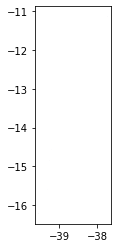

In [30]:
mapb.loc[mapb.DataDetec == '2021-03-03']

In [26]:
#mapb.DataDetec.unique().tolist()
mapb.loc[mapb.DataDetec == '2021-05-13'].to_file('sample_data/filtered_data/mapb_2021_05_13.shp')
mapb.loc[mapb.DataDetec == '2019-05-13'].to_file('sample_data/filtered_data/mapb_2019_05_13.shp')
mapb.loc[mapb.DataDetec == '2020-05-13'].to_file('sample_data/filtered_data/mapb_2020_05_13.shp')


In [35]:
mapb.loc[mapb.IDAlerta == 153796].bounds

,minx,miny,maxx,maxy
65906,-62.559969,-8.709238,-62.546125,-8.695663


In [32]:
from shapely.geometry import Point
import pandas as pd

In [49]:
red_point = Point(-62.56,-8.7)
polygon_index = mapb.distance(red_point).sort_values()
subset_10k = mapb.iloc[polygon_index.index[:10000]]

/var/folders/xs/vy6pl7mj16jg04kw8pzmxtsm0000gp/T/ipykernel_5913/4237767092.py:2: UserWarning: Geometry is in a geographic CRS. Results from 'distance' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  polygon_index = mapb.distance(red_point).sort_values()


In [74]:

#subset_10k.loc[subset_10k.DataDetec == '2019-01-01']
subset_10k['date'] = pd.to_datetime(subset_10k.DataDetec)
xxx = subset_10k.query('20190601 < date < 20190605' )
xxx.drop('date', axis=1).to_file('sample_data/filtered_data/mapb_2019_06_01_to_06_05.shp')

/Users/janpisl/miniconda3/envs/gee/lib/python3.9/site-packages/geopandas/geodataframe.py:1322: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super(GeoDataFrame, self).__setitem__(key, value)
/Users/janpisl/miniconda3/envs/gee/lib/python3.9/site-packages/geopandas/io/file.py:299: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,
